In [1]:
import gc

import tensorflow as tf
%matplotlib inline

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from keras_tuner.tuners import Hyperband

import matplotlib.pyplot as plt
import numpy as np

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.16.1


## CNN FASHION MNIST

In [2]:
from keras.optimizers.legacy import Adam

In [3]:
# Defining the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
batch_size = 128
classes = 10
epochs = 10

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = to_categorical(y_train, classes)
Y_test = to_categorical(y_test, classes)

In [6]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


## TUNER


In [31]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import tensorflow as tf

# Define a HyperModel
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, classes):
        self.input_shape = input_shape
        self.classes = classes

    def build(self, hp):
        input = Input(shape=self.input_shape, name='Input')
        x = input

        # Allow Keras Tuner to decide the number of convolutional layers
        for i in range(hp.Int('conv_layers', 1, 3)):
            x = Conv2D(filters=8 * (2 ** i),
                       kernel_size=(3, 3),
                       padding='same',
                       activation='relu',
                       name=f'Conv2D-{i + 1}')(x)
            x = MaxPool2D(pool_size=(2, 2), padding='same', name=f'MaxPool2D-{i + 1}')(x)

            # Allow Keras Tuner to decide whether to use dropout
            if hp.Boolean('conv_dropout'):
                x = Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1), name=f'Dropout-{i + 1}')(x)

        x = Flatten(name='Flatten')(x)
        output = Dense(units=self.classes, activation='softmax', name='Output')(x)
        model = Model(inputs=input, outputs=output)

        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Function to search for best hyperparameters
def search_best_hyperparameters(input_shape, classes, X_train, Y_train, epochs, batch_sizes=[64, 128, 256, 512]):
    np.random.seed(1402)
    tf.random.set_seed(1981)
    
    best_batch_size = None
    best_val_accuracy = 0
    
    for batch_size in batch_sizes:
        print(f"Testing batch size: {batch_size}")
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
        hypermodel = MyHyperModel(input_shape=input_shape, classes=classes)

        tuner = Hyperband(
            hypermodel,
            objective='val_accuracy',
            max_epochs=10,
            directory='fashion_mnist',
            project_name='final_really'+str(batch_size)
        )

        tuner.search(x=X_train, y=Y_train, epochs=epochs, callbacks=[early_stopping], batch_size=batch_size, validation_split=0.1)

        
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        val_accuracy = best_trial.score
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_batch_size = batch_size
            
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    The hyperparameter search is complete. The optimal number of convolutional layers is {best_hps.get('conv_layers')}
    and the optimal dropout rate is {best_hps.get('dropout_rate')} and optimal batch size is {best_batch_size}.
    """)

    return best_hps, tuner , best_batch_size



In [32]:
best_hps, tuner, best_batch_size = search_best_hyperparameters(input_shape, classes, X_train, Y_train, epochs = 10)

Trial 30 Complete [00h 00m 22s]
val_accuracy: 0.8791666626930237

Best val_accuracy So Far: 0.8805000185966492
Total elapsed time: 00h 06m 28s

    The hyperparameter search is complete. The optimal number of convolutional layers is 1
    and the optimal dropout rate is 0.5 and optimal batch size is 64.
    


In [33]:
best_batch_size

64

In [34]:
best_model = tuner.hypermodel.build(best_hps)

In [35]:
import json
tuner.get_best_hyperparameters(num_trials=1)[0]
json_str = json.dumps(best_hps.values, indent=4)

# Print the pretty-printed JSON string
print(json_str)

{
    "conv_layers": 1,
    "conv_dropout": false,
    "dropout_rate": 0.5,
    "tuner/epochs": 10,
    "tuner/initial_epoch": 4,
    "tuner/bracket": 2,
    "tuner/round": 2,
    "tuner/trial_id": "0012"
}


In [36]:
history = best_model.fit(X_train, Y_train, epochs=30, batch_size=best_batch_size, validation_split=0.1)

Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7261 - loss: 0.8363 - val_accuracy: 0.8625 - val_loss: 0.4016
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8715 - loss: 0.3766 - val_accuracy: 0.8778 - val_loss: 0.3560
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8854 - loss: 0.3330 - val_accuracy: 0.8847 - val_loss: 0.3337
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8924 - loss: 0.3090 - val_accuracy: 0.8897 - val_loss: 0.3194
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8971 - loss: 0.2926 - val_accuracy: 0.8925 - val_loss: 0.3096
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9011 - loss: 0.2801 - val_accuracy: 0.8948 - val_loss: 0.3025
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9049 - loss: 0.2700 - val_accuracy: 0.8953 - val_loss: 0.2972
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9074 - loss: 0.2618 - val_accuracy: 0.

In [37]:
hs_eval = best_model.evaluate(X_test, Y_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8943 - loss: 0.3184


In [38]:
hs_eval

[0.31235745549201965, 0.8935999870300293]

In [41]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

Train Loss     : 0.19294
Validation Loss: 0.28491
Test Loss      : 0.31236
---
Train Accuracy     : 0.93185
Validation Accuracy: 0.90067
Test Accuracy      : 0.89360



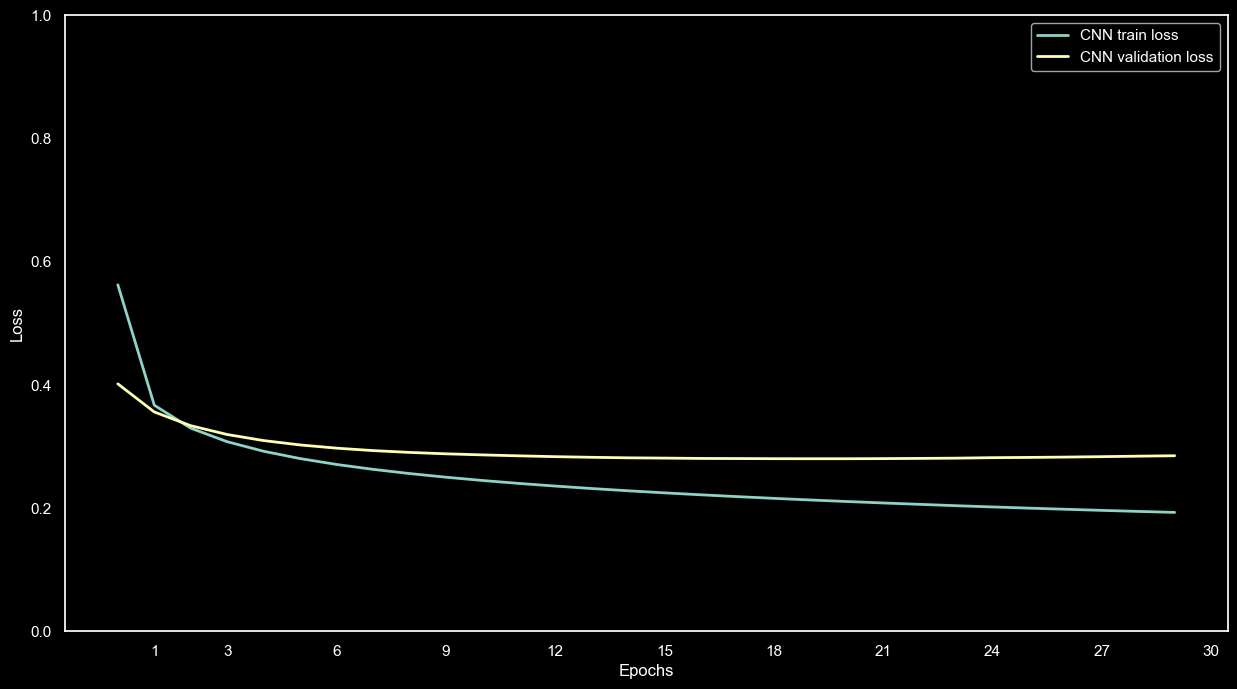

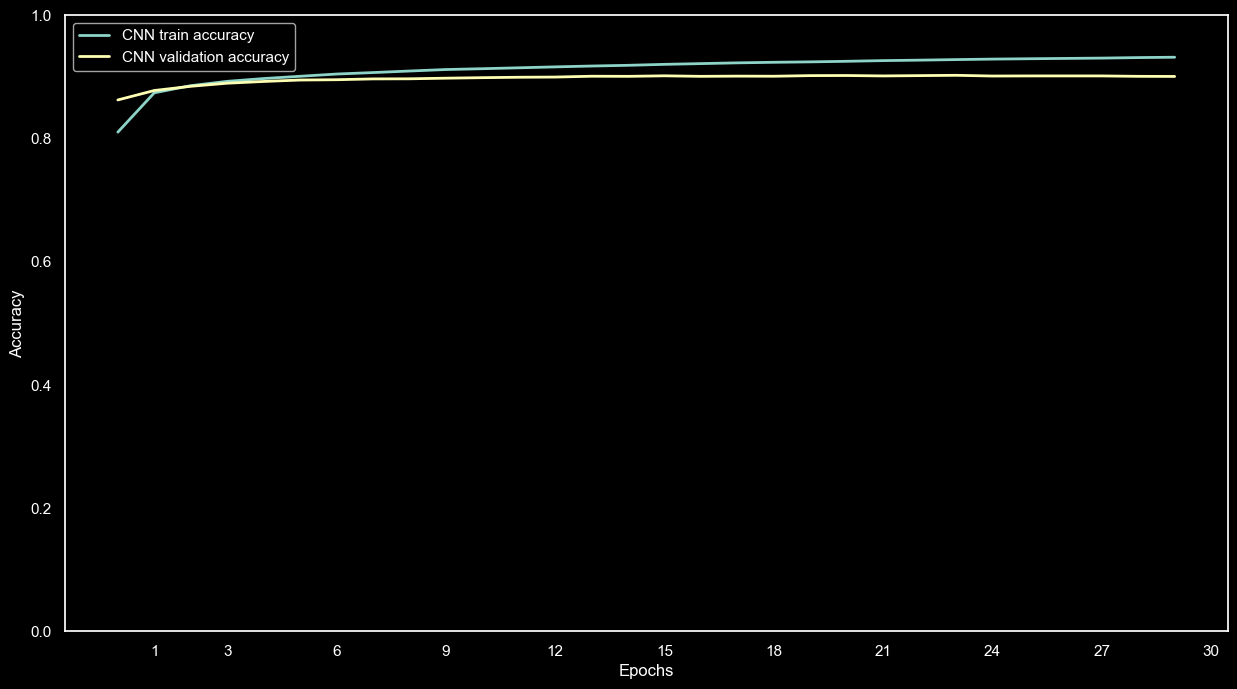

In [42]:
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(hs_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(hs_eval[1]))

# Plot train and validation error per epoch.
plot_history(hs={'CNN': history}, epochs=30, metric='loss')
plot_history(hs={'CNN': history}, epochs=30, metric='accuracy')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


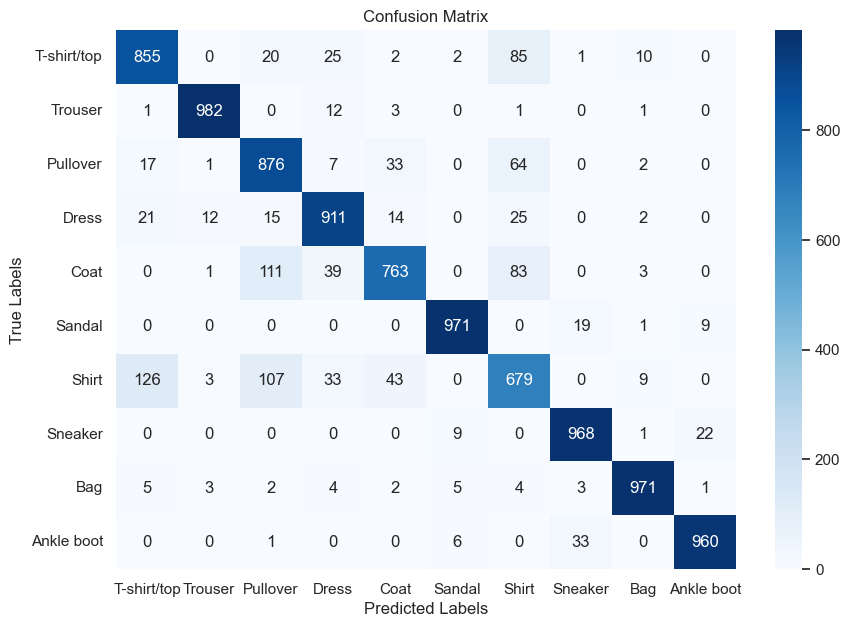

In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `predictions` are the raw outputs from your model, e.g., softmax probabilities
# Convert predictions and true labels from one-hot encoded to class indices
predictions = np.argmax(best_model.predict(X_test), axis=-1)
y_test_indices = np.argmax(Y_test, axis=-1)  # Only if y_test is one-hot encoded

sns.set_theme(style="white")
# Calculate the confusion matrix
cm = confusion_matrix(y_test_indices, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming your model's prediction function returns the class probabilities
predictions_prob = best_model.predict(X_test)  # Get model predictions for the test set

# Convert probabilities to predicted class labels
predictions = np.argmax(predictions_prob, axis=1)

# Assuming y_test is one-hot encoded, convert it to single integer labels
y_true = np.argmax(Y_test, axis=1)

# Generate the classification report
report = classification_report(y_true, predictions, target_names=class_names)

print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.77      0.88      0.82      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.89      0.76      0.82      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.72      0.68      0.70      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [45]:
misclassified_indices = np.where(predictions_prob != y_test)[0]
y_test_class_indices = np.argmax(Y_test, axis=1)

/var/folders/zs/shjf_6j915n707ks3n6jncwr0000gn/T/ipykernel_74252/2969838270.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misclassified_indices = np.where(predictions_prob != y_test)[0]


In [46]:
def plot_images(images, titles, pred_class_name, nrows=1, ncols=3):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    fig.suptitle(f"Misclassified as: {pred_class_name}", fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(titles[i], fontsize=8)
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()



[ 4 40 42]


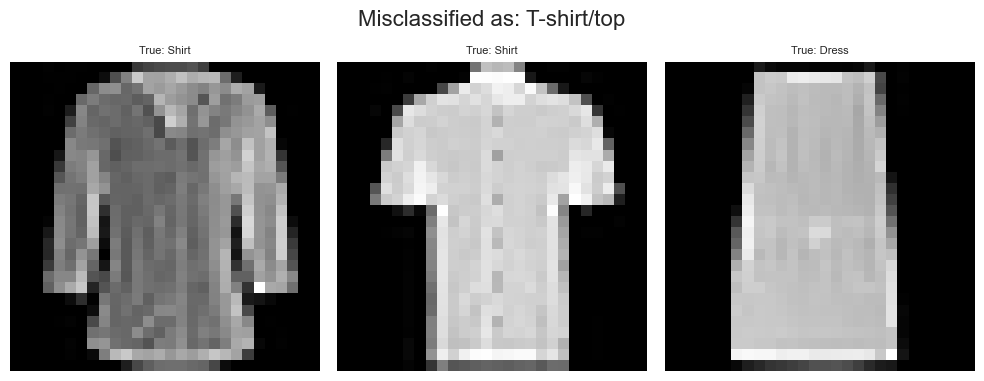

[ 32 635 661]


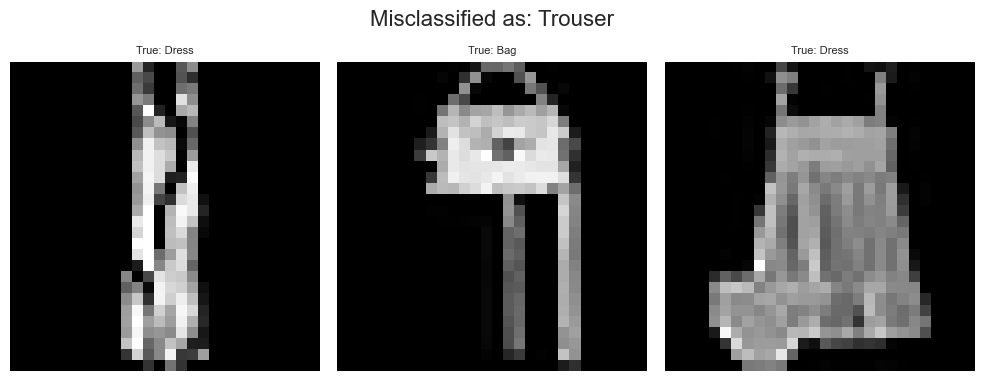

[166 239 244]


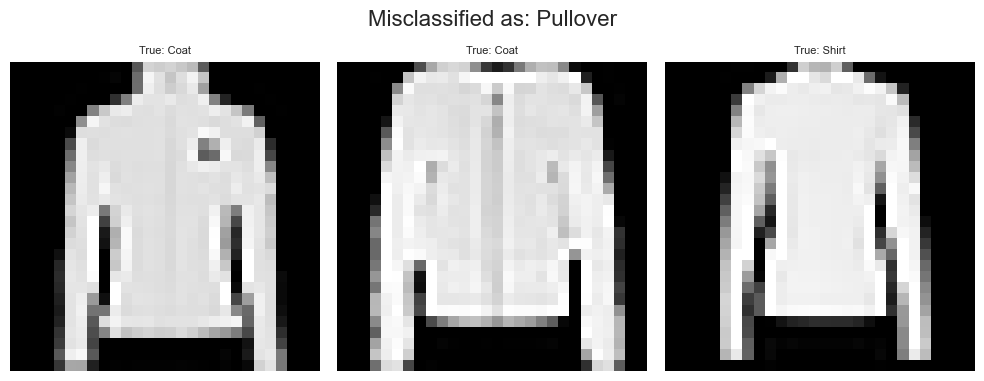

[ 98 147 150]


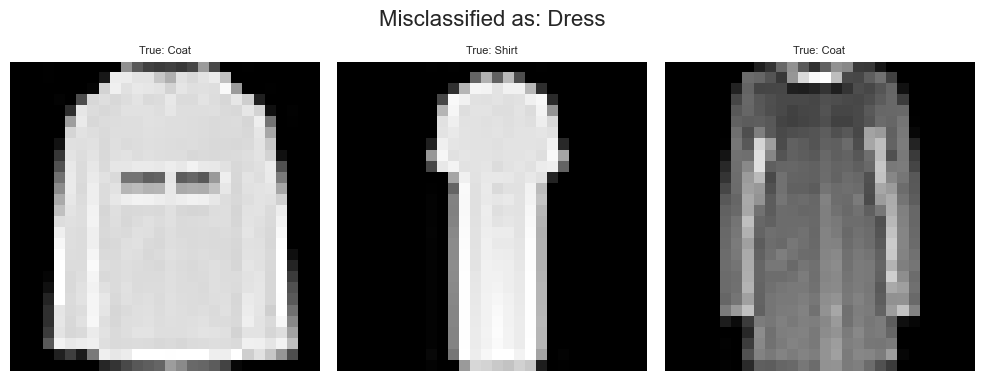

[135 457 664]


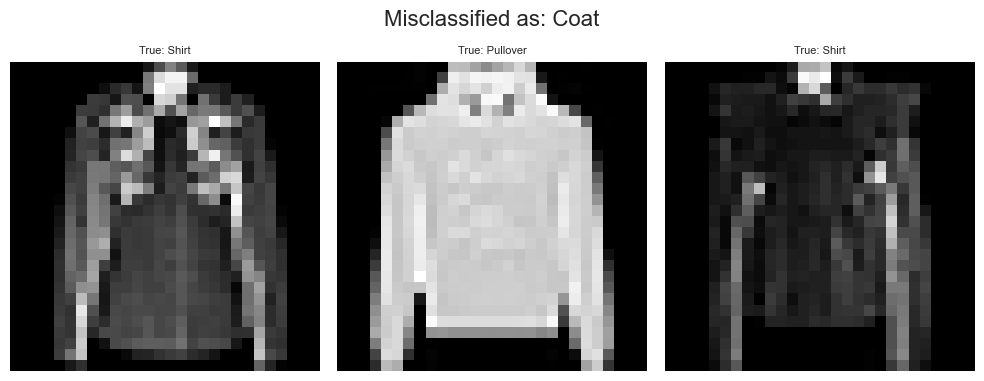

[  23  972 1300]


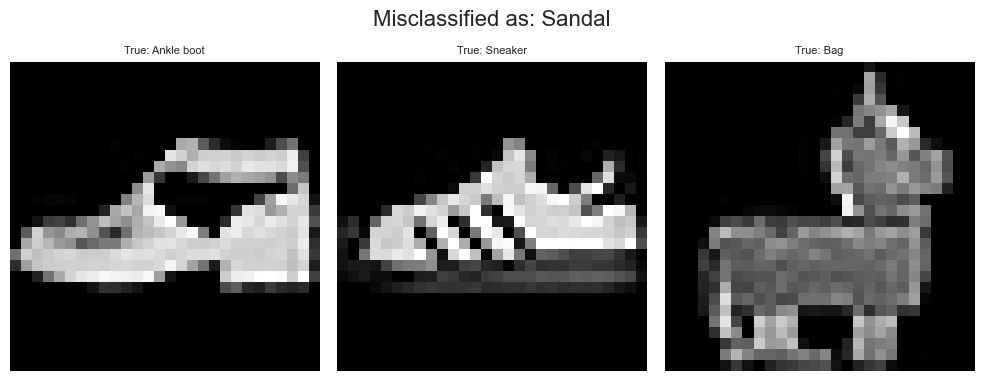

[25 49 51]


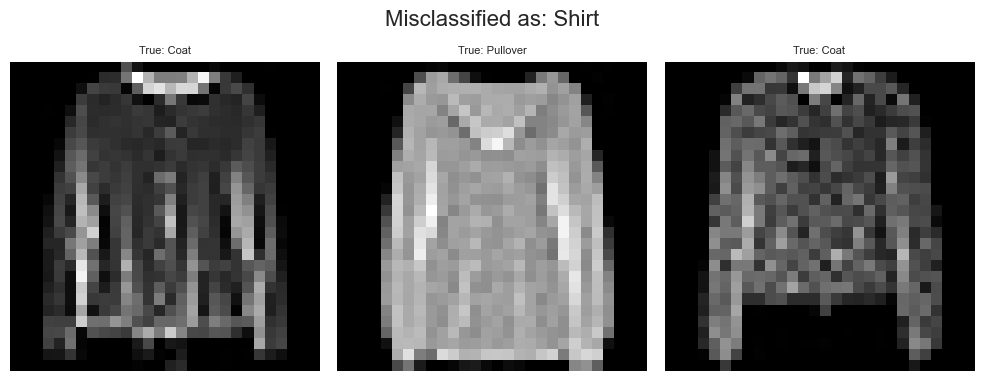

[ 68 316 441]


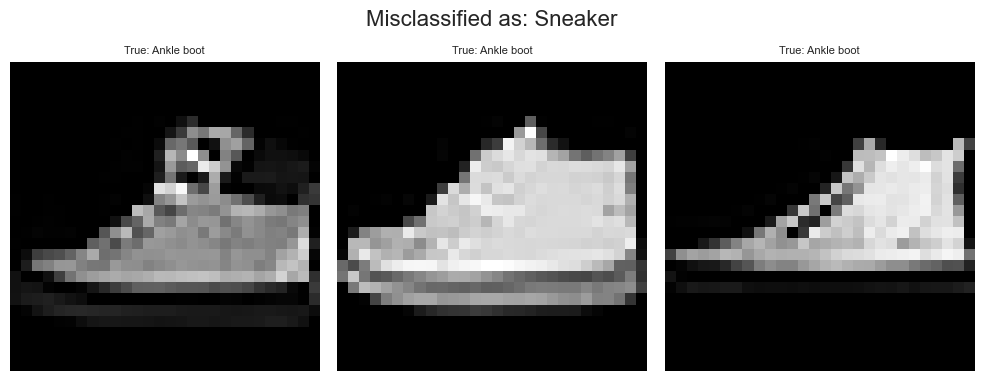

[ 12 881 984]


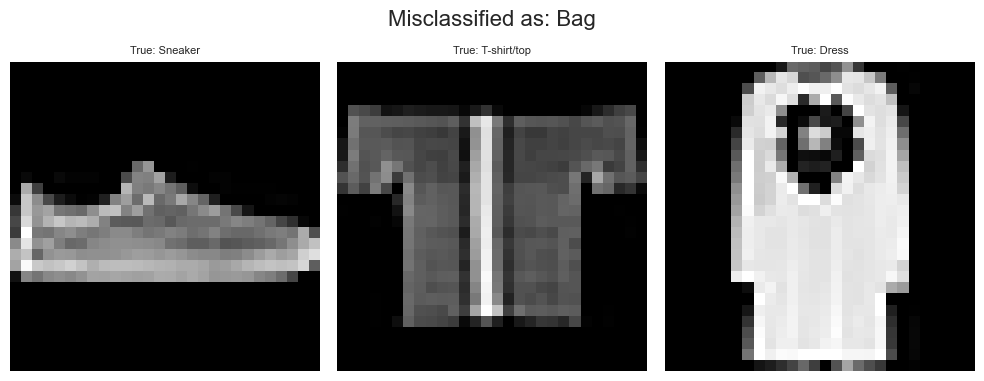

[800 902 945]


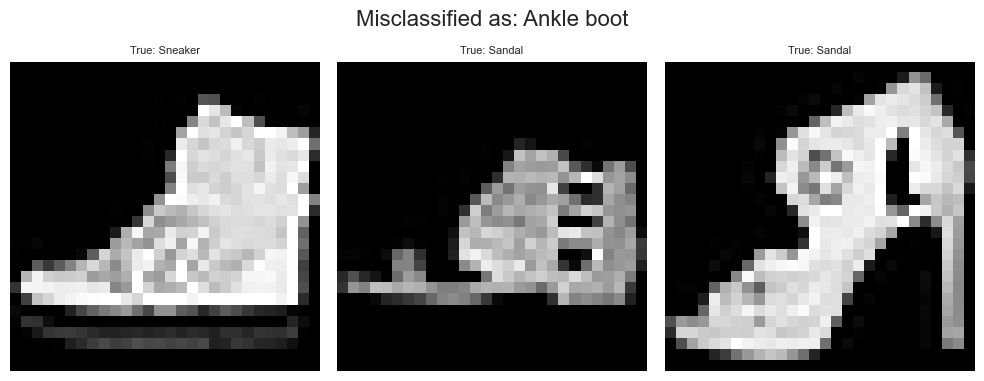

In [47]:
for pred_class_idx, pred_class_name in enumerate(class_names):
    # Find indices where the prediction was pred_class_idx but the true class was different
    misclassified_indices = np.where((predictions == pred_class_idx) &
                                     (y_test_class_indices != pred_class_idx))[0]

    # Select a subset of misclassified images for this predicted class
    subset_indices = misclassified_indices[:3]  # Adjust as needed
    print(subset_indices)
    if len(subset_indices) > 0:
        # Ensure images are reshaped from (784,) to (28, 28) for plotting
        images = [X_test[i].reshape(28, 28, 1) for i in subset_indices]
        titles = [f"True: {class_names[y_test_class_indices[i]]}" for i in subset_indices]

        plot_images(images, titles, pred_class_name)

In [20]:
best_model.summary() 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D-1 (Conv2D)               │ (None, 28, 28, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPool2D-1 (MaxPooling2D)      │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │        15,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,312 (184.82 KB)

 Trainable params: 15,770 (61.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,542 (123.21 KB)